In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

C:\Users\14090\AppData\Local\Temp\ipykernel_13112\3623846850.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


## 1. Compile or obtain a pre-compiled version

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\IncaMicroplastics\incamicroplastics.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

## 2. Load observed datasets and model structure

The Mobius repositiory contains example data from two catchments: the Tarland Burn in North-eastern Scotland, and the Morsa catchment in South-eastern Norway. **The descriptive text in this notebook assumes you're working through the Morsa example**, but code is provided for both. Examples of the input data format can be found in e.g. `Applications/SimplyP/Morsa`.

In [3]:
#dataset = wr.DataSet.setup_from_parameter_and_input_files('..\..\Applications\IncaC\Boyne\persist_params_Boyne.dat', '..\..\Applications\IncaC\Boyne\incac_inputs_Boyne.dat')
dataset = wr.DataSet.setup_from_parameter_and_input_files(
    '..\..\Applications\IncaMicroplastics\Vansjo\incamp_params_Vansjo.dat', # parameters
    '..\..\Applications\IncaMicroplastics\Vansjo\incamp_inputs_Vansjo.dat' # inputs
)

In [22]:
dataset.get_input_list()
# dataset.get_input_series(name="Observed Q Kure", indexes="")

[('Actual precipitation', 'required'),
 ('Air temperature', 'required'),
 ('Abstraction flow', 'required'),
 ('Effluent flow', 'required'),
 ('Grain input to land', 'required'),
 ('Observed Q Kure', 'additional'),
 ('Observed SS Kure', 'additional')]

In [53]:
dataset.get_index_sets()
# dataset.get_indexes(index_set="Reaches")
# dataset.get_equation_list()

['Landscape units', 'Soils', 'Reaches', 'Grain class']

## 3. Link observed and simulated datasets

In order to assess model performance, we need to be able to compare simulated values to observations. The code below links five simulated data series (Q, SS, TP, TDP and PP) to the relevant observed datasets (as defined in the Mobius `dataset` object).

**Note:** "Kure" is a monitoring location in the Morsa catchment, which was used as an "index" when setting up the SimplyP model. The `comparisons` list below contains five tuples, each mapping a simulated dataset in the model to an observed data series. The names of the observed data series should match those present in the input `.dat` file.

In [39]:
comparisons = [
    ('Reach flow', ['Kure'], 'Observed Q Kure', []),
    # ('Reach flow', ['Kure'], 'Observed SS', [])
]

## 4. Manual calibration

The original data files (`MorsaParameters_v0-3.dat` and `MorsaInputs.dat`) used to create this Mobius `dataset` include deafult values and plausible ranges for each model parameter. The code below lists these default values for all the `double` parameters defined in the model (these are the ones available for calibration).

In order to easily refer to model parameters in the subsequent code, and to facilitate creation of tidy plots, it is useful to have abbreviated parameter names, called 'short_name'. The main name is often defined by the model itself, but you have to provide abbreviations for the indexes used in the particular dataset.

**Note:** Short names for model parameters **must not** begin with `err_`, otherwise conflicts will arise with error terms used in the MCMC analysis (see section 6.2, below).

In [40]:
index_short_name = {'All':'A', 'Quick':'q', 'Soilwater':'s', 'Groundwater':'g', 'Coull':'r'}

param_df = cu.get_double_parameters_as_dataframe(dataset, index_short_name=index_short_name)
pd.options.display.max_rows = 999
# param_df
param_df.head()

,name,short_name,unit,index,min_value,initial_value,max_value
0,Solver resolution,,dimensionless,(),0.001,0.100000,0.5
1,Snow multiplier,Msnow_A,dimensionless,"(All,)",0.500,1.000000,1.5
2,Snow melt temperature,Tsnow_A,°C,"(All,)",-4.000,0.000000,4.0
3,Degree day melt factor,DDFmelt_A,mm/°C/day,"(All,)",1.000,1.482074,4.0
4,Rain multiplier,Mrain_A,dimensionless,"(All,)",0.500,1.000000,1.5


Note the `index` column in this dataframe, which specifies how each parameter varies within the model structure. For example, the `Vegetation cover factor` takes different values for different land use classes, while the `Mean slope of land` parameters vary both by land class and river reach.

For this particular dataset, the default values in the `initial_value` column were informed by manual calibration using the [MobiView GUI application](https://github.com/NIVANorge/Mobius#the-mobiview-graphical-user-interface). We can easily run the model with these values and assess the goodness-of-fit. The functions below produce one plot and one set of summary statistics for each dataset in `comparisons`.

In [41]:
dataset.run_model()

True


Goodness of fit for Reach flow [Kure] vs Observed Q Kure []:
Mean error (bias): -0.000336
Mean absolute error: 2.069134
Root mean square error: 3.587177
Nash-Sutcliffe coefficient: 0.719724
Number of observations: 10900



<AxesSubplot:xlabel='Date', ylabel='m3/s'>

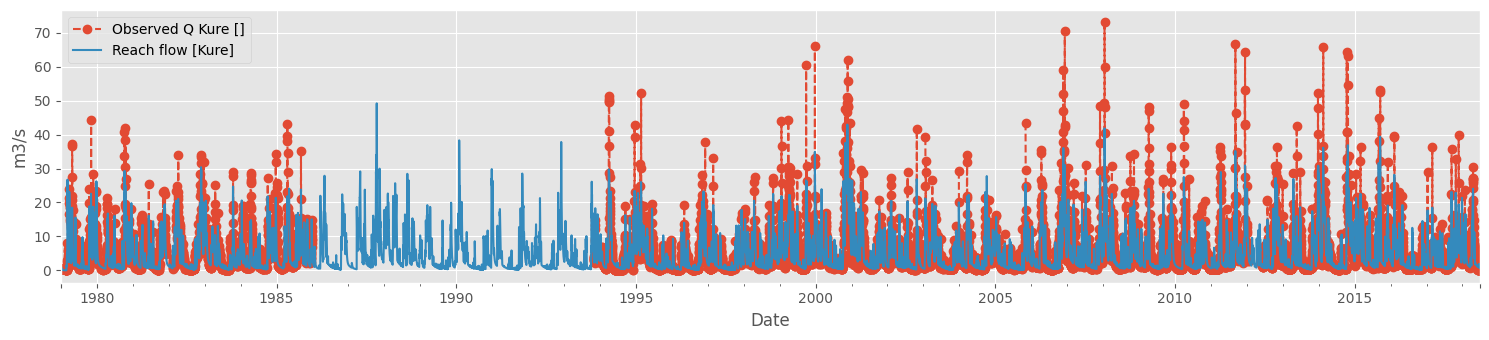

In [42]:
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

## 5. Auto-calibration

### 5.1. Choose parameters to calibrate

Parameter values should be informed by system knowledge wherever possible. In this example, we will choose to calibrate a sub-set of model parameters that are poorly constrained.

The code below selects **11 parameters** for further investigation.

**Note:** Several Pandas methods can be used to subset `param_df`. The approach illustrated below is simple.  Consider using e.g. [`df.query`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) for a different way.

In [54]:
wanted_names = [
    'Msnow', 'Tsnow', 'DDFmelt', 'DDET', 'Tc_s', 'Tc_g', 'perc_A_s_s', 'perc_A_s_g',
]

calib_df = param_df[[any([sn.startswith(n) for n in wanted_names]) for sn in param_df['short_name']]].reset_index(drop=True)
calib_df

,name,short_name,unit,index,min_value,initial_value,max_value
0,Snow multiplier,Msnow_A,dimensionless,"(All,)",0.50,1.000000,1.5
1,Snow melt temperature,Tsnow_A,°C,"(All,)",-4.00,0.000000,4.0
2,Degree day melt factor,DDFmelt_A,mm/°C/day,"(All,)",1.00,1.482074,4.0
3,Degree day evapotranspiration,DDET_A,mm/°C/day,"(All,)",0.05,0.195605,0.2
4,Time constant,Tc_g_A,days,"(Groundwater, All)",1.00,50.126234,9999.0


Having defined a dataframe of parameters we wish to calibrate, complete with short names, initial values and minimum to maximum ranges, we can instantiate an [LMFit Parameters](https://lmfit.github.io/lmfit-py/parameters.html) object, which makes it easy to keep track of bounded parameter values. 

In [55]:
params = cu.parameter_df_to_lmfit(calib_df)

Note the warning printed above: in the original model dataset, the `alphaPET` parameter (i.e. the "PET multiplication factor") has an initial value that is equal to the maximum of 1. This can cause problems for gradient-based optimisers, because in order to estimate the initial gradient the algorithm needs to "explore" the area immediately around the starting point. 

Fortunately, it is easy to modify the prior ranges for each parameter, as illustrated in the code below. We will increase the maximum value for `alphaPET` to 1.5, as well as adjusting ranges for some of the other parameters. Initial values can also be changed using e.g. `params['DDFmelt'].value = 2.5`, and calibration can be disabled entirely for specific parameters using e.g. `params['DDFmelt'].vary = False`. Note that parameters must be referred to by their `short_name` attribute.

In a Jupyter notebook, `params` will return a dataframe showing the current user choices for the calibrating parameters. (In a Python script/terminal,  `params.pretty_print` provides similar output).

In [57]:
# Optionally refine prior ranges
# params['perc_A_s_g'].set(expr = '1.0-perc_A_s_s')
# params['Tc_s_A'].min = 1.0
# params['Tc_s_A'].max = 10.0
params['Tc_g_A'].min = 30.0
params['Tc_g_A'].max = 200.0

params

name,value,initial value,min,max,vary
Msnow_A,1.00000000,1.0,0.50000000,1.50000000,True
Tsnow_A,0.00000000,0.0,-4.00000000,4.00000000,True
DDFmelt_A,1.48207425,1.48207425381599,1.00000000,4.00000000,True
DDET_A,0.19560513,0.195605130602712,0.05000000,0.20000000,True
Tc_g_A,50.1262343,50.1262343061451,30.0000000,200.000000,True


### 5.2. Least squares optimisation

[LMFit](https://lmfit.github.io/lmfit-py/index.html) provides a convenient API to several Python optimisers (see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for details). 

Some of these optimisers also provide confidence intervals and correlations for the "best" parameters. These are approximate, but they provide useful information about the model and may help you to refine parameter ranges (or even the model structure) before undertaking a more comprehensive calibration exercise using MCMC (see below).

All of these optimisers aim to minimise the sum of squared residuals. From a "formal" statistical point of view, this is equivalent to assuming a likelihood function with independent and identically distributed (i.i.d.) Gaussian errors, which may not be the best choice. Nevertheless, minimising the sum of squared errors is often a good starting point, especially given the range of optimisers available.

**Note:** Performance can vary dramatically between optimisers, so it's often a good idea to try a few different alternatives. This will also allow you to check whether the same "optimum" is identified by the various algorithms.

In [58]:
%%time
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, skip_timesteps=365)
print('Optimization results\n')
lmfit.report_fit(res)
print('\n\nOptimized parameter values:\n')
res.params.pretty_print(precision=3)

cu.set_parameter_values(res.params, dataset)
dataset.write_parameters_to_file('optimized_params.dat')

Optimization results

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 983
    # data points      = 10542
    # variables        = 5
    chi-square         = 126049.710
    reduced chi-square = 11.9625804
    Akaike info crit   = 26167.9602
    Bayesian info crit = 26204.2758
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    Msnow_A:    1.01449080 (init = 1)
    Tsnow_A:    1.06329818 (init = 0)
    DDFmelt_A:  2.90568866 (init = 1.482074)
    DDET_A:     0.19738738 (init = 0.1956051)
    Tc_g_A:     40.3820252 (init = 50.12623)


Optimized parameter values:

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
DDET_A        0.197     0.05      0.2     None     True     None     None
DDFmel

The optimiser has run the model 264 times in around 50 seconds. Output includes estimated parameter correlations and confidence intervals: note, for example, the `Stderr` column that has been added to the parameters table immediately above.

### 5.3. Visualise results

To see the model output for the optimised parameter values, first use `set_parameter_values` to update the default values, and then re-run the model, as above.


Goodness of fit for Reach flow [Kure] vs Observed Q Kure []:
Mean error (bias): -0.005936
Mean absolute error: 2.021461
Root mean square error: 3.517161
Nash-Sutcliffe coefficient: 0.730558
Number of observations: 10900



<AxesSubplot:xlabel='Date', ylabel='m3/s'>

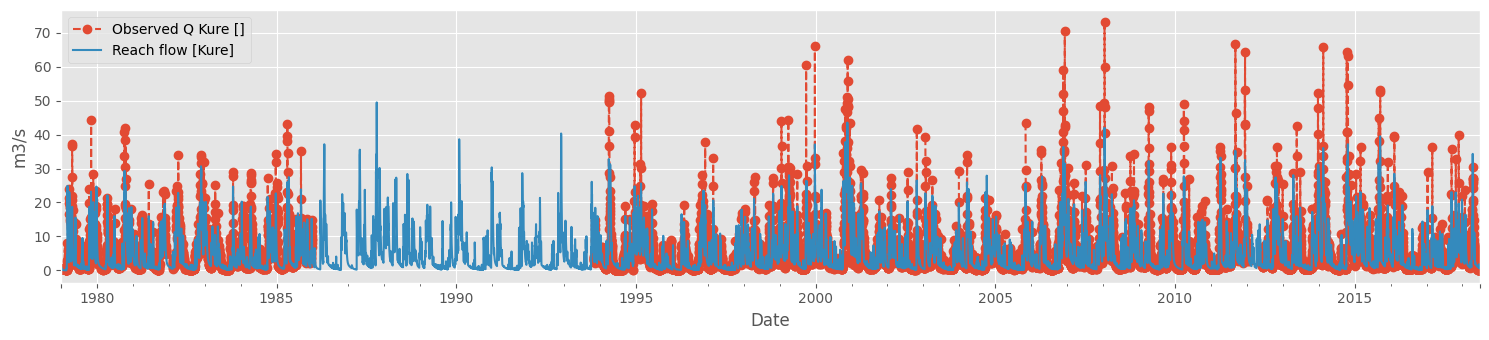

In [59]:
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

Comparing the goodness-of-fit statistics from the optimiser to those from the manual calibration (section 4), you can see that the optimiser has certainly found "better" parameter sets from the point of view of the summary statistics (Nash-Sutcliffe scores etc.). However, if you look at the plots, the "by eye" fit from the manual calibration is still clearly better. This is because the optimiser is minimising the sum of squared errors - a metric that strongly penalises large outliers. The "best" result from the optimiser therefore tries to fit the peaks in the observed series, at the expense of poor fits elsewhere. Since metrics like N-S are closely related to the sum of squared errors, this approach gives impressive summary statistics, but actually rather poor simulations. The choice of appropriate summary metrics for assessing water quality time series is still an active area of research.

## 6. Full calibration and uncertainty analysis using MCMC

Bayesian MCMC provides much more comprehensive information regarding model performance, but it's also more complicated and computationally intensive. Although it's perfectly possible to begin your model analysis with MCMC, it's usually a good idea to experiment with the optimisation options described above first, and then apply MCMC as a second step.

### 6.1. Likelihood function

The (log) likelihood function describes the probability that the model, when run with a given set of parameters, will reproduce the observed data. Formulating an appropriate likelihood function is both important and challenging, and there's a lot of literature on the subject. In this example, we'll assume **heteroscedastic**, independent Gaussian errors, which is one step better than the simplest/commonest i.i.d. approach. If you'd like to know more about where this approach comes from, see [here](http://jamessample.github.io/enviro_mod_notes/) (especially [section 2 of notebook 6](https://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/06_Beyond_Metropolis.ipynb#2.-Choosing-a-likelihood-function)).

In order to run parallelised MCMC, you need to create a separate Python file similar to `simplyp_calib_uncert.py`. This file defines your log likelihood function and provides the Mobius `dataset` as a "top-level object", which makes it amenable to parallel processing.

**To do**

 * See if we can figure out parallelisation from within Jupyter?

### 6.2. Error terms

Using a formal statistical likelihood involves estimating some additional error terms. We'll assume that the error distribution for all three phosphorus species is the same, so we need three terms in total (for Q, SS and P). These can be added to the result obtained from the optimiser in section 5, above.

**Note:** Names for error terms **must** begin with `err_`. Conversely, short names for model parameters **must not** begin with `err_`.

In [60]:
res.params.add('err_q', value = 0.5, min = 0.05, max = 3)

error_param_dict = {'Observed flow': 'err_q'}

res.params
# res.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

name,value,initial value,min,max,vary
Msnow_A,1.01449080,1.0,0.50000000,1.50000000,True
Tsnow_A,1.06329818,0.0,-4.00000000,4.00000000,True
DDFmelt_A,2.90568866,1.48207425381599,1.00000000,4.00000000,True
DDET_A,0.19738738,0.195605130602712,0.05000000,0.20000000,True
Tc_g_A,40.3820252,50.1262343061451,30.0000000,200.000000,True
err_q,0.50000000,0.5,0.05000000,3.00000000,True


We also need to define a dictionary matching each of the observed data series in `comparisons` to the appropriate error term.

**Note:** The `user_data={}` is required. This dictionary will be updated after the MCMC to contain the median and MAP parameter estimates.

In [61]:
## Link error params to model datasets for Morsa
#error_param_dict = {'Observed Q':          'err_q',
#                    'Observed SS at Kure': 'err_ss',
#                    'Observed TP at Kure': 'err_p',
#                    'Observed TDP at Kure':'err_p',
#                    'Observed PP at Kure': 'err_p',
#                   }

# Link error params to model datasets for Tarland
error_param_dict = {'observed Q':  'err_q',
                    'observed SS': 'err_ss',
                    'observed TDP':'err_p',
                    'observed PP': 'err_p',
                   }

**Note:** LMFit parameter objects provide additional features for linking and combining parameters using the `expr` argument - see [here](https://lmfit.github.io/lmfit-py/constraints.html) for further details. The error terms for TDP and PP could equally well have been defined as follows:

    # Add error params
    res.params.add('err_q', value=0.5, min=0.05, max=3, user_data={})
    res.params.add('err_ss', value=0.5, min=0.05, max=5, user_data={})
    res.params.add('err_tp', value=0.5, min=0.05, max=2, user_data={})
    res.params.add('err_tdp', expr='err_tp', user_data={})             # Use a single error term for all P types
    res.params.add('err_pp', expr='err_tp', user_data={})              # Use a single error term for all P types 
    
Although not necessary here, this kind of syntax is especially useful when dealing with parameters representing proportions, where the total need to be constant.

### 6.3. MCMC options

In order to run the MCMC in parallel, all the settings from above are added to a dictionary and "pickled". Some additional options are specified below.

In [63]:
nworkers = 8
ntemps   = 1
nsteps   = 10000
nwalk    = 100
nburn    = 1000
thin     = 1
init_chains = 'uniform'
skip_timesteps = 365
result_path = r'pickled\\mcmc_results.pkl'
chain_plot_path = r'plots\\chains.png'
corner_plot_path = r'plots\\corner.png'

settings_dict = {'params':res.params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('pickled\\mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

### 6.4. Run MCMC

**Important note:** Before running the code below, it is important to check the dataset paths in `simplyp_calib_uncert.py` **lines 62 and 63** to make sure they match your catchment of interest (i.e. Morsa or Tarland). At present, these paths cannot be passed "dynamically" using the dictionary above, as this breaks parallelisation of the MCMC (see section 6.1, above). We hope to fix this eventually, but for the present these dataset paths must be hard-coded. The lines to edit look like this

    dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/XXXX/XXXXParameters_v0-3.dat', 
                                                              '../../Applications/SimplyP/XXXX/XXXXInputs.dat')
                                                              
and the four occurrences of `XXXX` should be replaced with either `Tarland` or `Morsa`.

In [65]:
%run -i persist_calib_uncert.py

RuntimeError: ERROR: Tried to open file "..\..\Applications\Persist\Haelva\persist_inputs_Haelva.dat", but was not able to.


In [38]:
with open('pickled\\mcmc_results.pkl', 'rb') as handle:
    result = pickle.load(handle)
    
cu.set_parameter_values(result.params, dataset)
dataset.run_model()

dataset.write_parameters_to_file('mcmc_map_params.dat')

In [18]:
highest_prob = np.argmax(result.lnprob)
hp_loc = np.unravel_index(highest_prob, result.lnprob.shape)
mle_soln = result.chain[hp_loc]
print(highest_prob)
print(mle_soln)

9430
[3.12397846e+00 2.55676429e+00 1.55611877e-01 1.99544266e+00
 6.87352323e+01 1.48753151e-02 1.15521800e-04 7.94123316e-01
 3.77625619e-01]



Goodness of fit for Reach flow [Outlet] vs Observed discharge outlet []:
Mean error (bias): 0.771484
Mean absolute error: 4.025048
Root mean square error: 7.508794
Nash-Sutcliffe coefficient: 0.762004
Number of observations: 3557



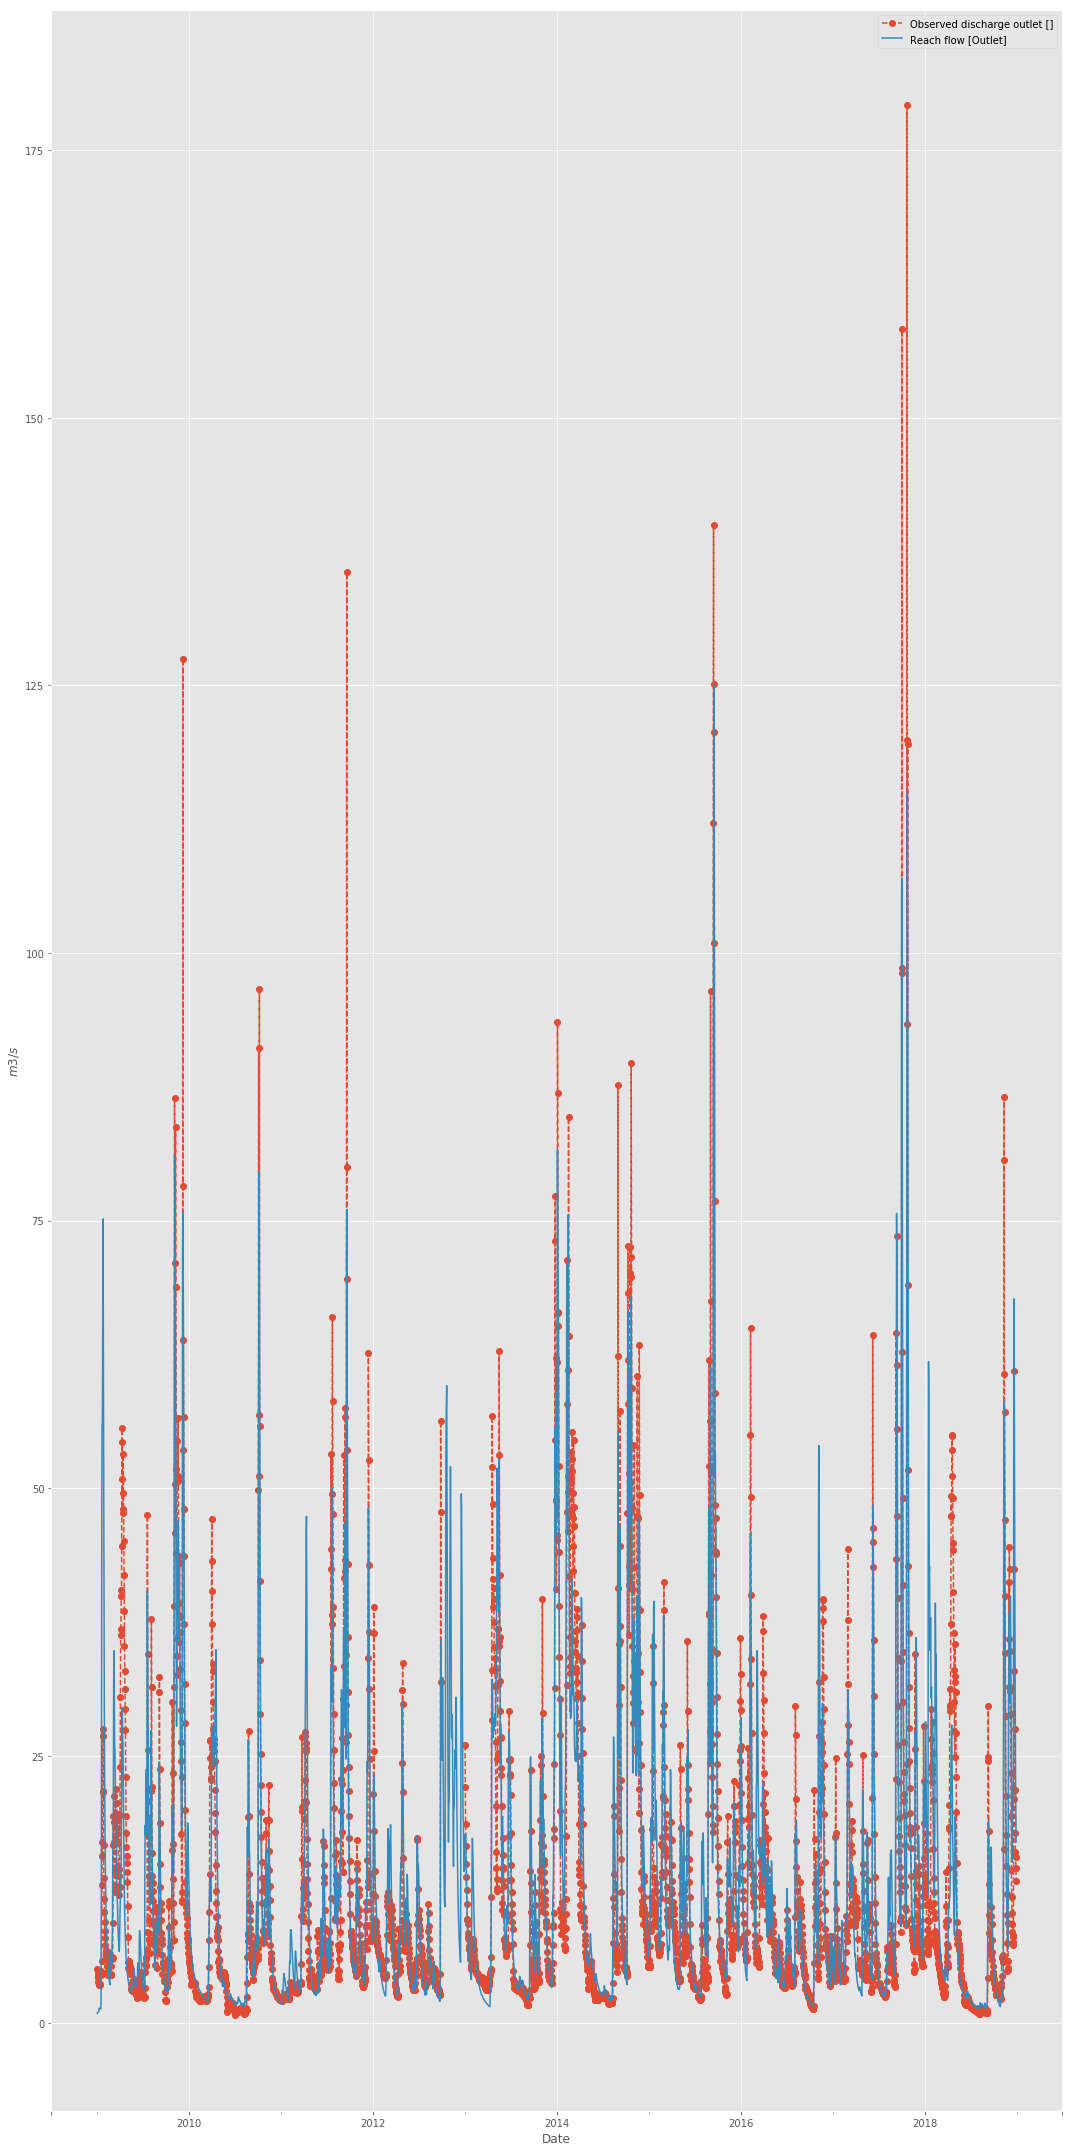

In [22]:
#par = result.params
#TODO: automate this! (we don't want to set the computed ones, but we need them to recompute based on what we set)
#par['T_melt'].set(value = mle_soln[0])
#par['DDfmelt'].set(value = mle_soln[1])
#par['DDfet'].set(value = mle_soln[2])
#par['T_s'].set(value = mle_soln[3])
#par['T_g'].set(value = mle_soln[4])
#par['a_V'].set(value = mle_soln[5])
#par['runoff_r'].set(value = mle_soln[6])
#par['runoff_s'].set(value = mle_soln[7])
#par['err_q']

#cu.set_parameter_values(par, dataset)
#dataset.run_model()
#cu.print_goodness_of_fit(dataset, comparisons)
#cu.plot_objective(dataset, comparisons)

#dataset.write_parameters_to_file('mcmc_map_params.dat')